* [x] Aplicar filtro passa faixa 3 ou 4 vezes
* [x] Usar psd welch para setar os segundos do janelamento.
* [x] O psd retorna uma matriz e nela a gente olha quais são as colunas correspondentes a cada frequência
* [x] Printa valores para cada um baseado na média das frequências (média de alpha, média beta...)
* [ ] Salvar em um buffer a média de cada frequência
* [ ] Quando o alpha for maior, calcular a diferença dele com o segundo maior valor
* [ ] Mapear a diferença para uma escala de 0 a 100 ou 0 a 255
* [ ] Antes de jogar na escala, aplicar log2 no valor da diferença (talvez)

*******Dados originais*******



<ipython-input-24-5edd0077f630>:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd()


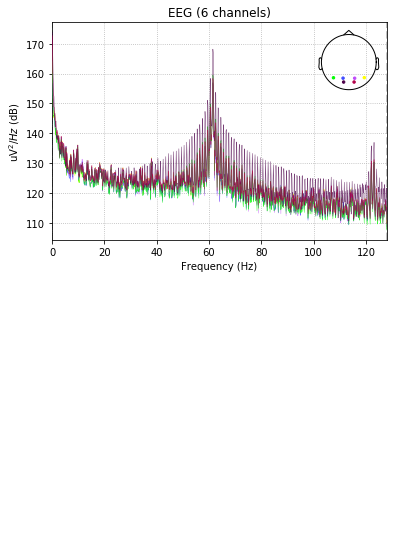

*******Dados com filtro notch*******



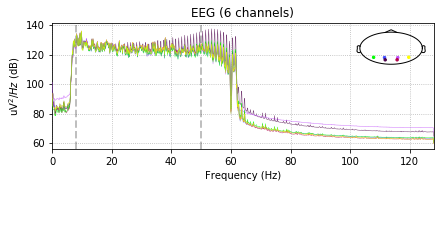

*******Dados com filtro bandpass*******



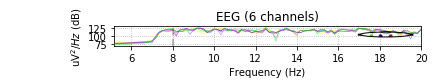

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

0
1
2
3
4
5


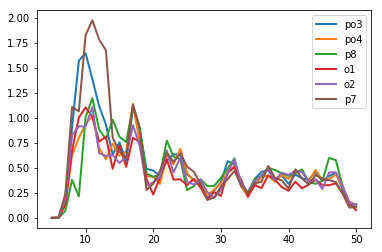

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import numpy as np
from copy import deepcopy
from mne.time_frequency import psd_welch as pw

ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']

def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    compactData = []
    for i in range(len(data)):
        if i >= 6:
            compactData.append(data[i])

    return compactData

def convert(data):
    temp = []
    line = data.split(',')

    for e in range(len(line)):
        if e > 0 and e <= 6:
            temp.append(float(line[e]))
    
    return temp

def separate_data(data):
    index = []
    temp = []
    count = 0

    for e in range(len(data)):
        idx = data[e].split(',')[0]
        if int(idx) == 255 and count == 255:
            index.extend(temp)
            temp = []
            count = 0
        elif int(idx) == 255 and count < 255:
            temp = []
            count = 0
        else:
            temp.append(convert(data[e]))
            count += 1
    
    return index
    
data = load_data('dataset_alpha/RAW_00.txt')
newData = separate_data(data)

def plot_graph(data):
    newData = np.asarray(data)
    newData = newData.T
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(newData, info, verbose=False)
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    print("*******Dados originais*******\n")
    raw.plot_psd()
    return raw

raw = plot_graph(newData)

def apply_notch(raw):
    newRaw = deepcopy(raw)
    newRaw.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
    newRaw.filter(8., 50., fir_design='firwin')
    
    print("*******Dados com filtro notch*******\n")
    newRaw.plot_psd(area_mode='range', verbose=False)
#     print()
    
apply_notch(raw)


def apply_bandpass(raw):
    newRaw = deepcopy(raw)
    
    for i in range(0, 9):
        newRaw.filter(l_freq=8., h_freq=50.)
    
    print("*******Dados com filtro bandpass*******\n")
    newRaw.plot_psd(area_mode='range', fmin=5, fmax=20, tmin=244, tmax=250, verbose=False)
#     print()
    return(newRaw)

def extract_avg(ch_names, newData):
    newData = np.array(newData)
    newData = newData.T
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    
    raw = mne.io.RawArray(newData, info, verbose=False)    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    raw, media = mne.set_eeg_reference(raw, 'average', verbose=False)

    return media

def plot_time_frequency(raw, i, f):
    alpha = []
    beta = []
    theta = []
    gamma = []
    
    newRaw = (apply_bandpass(raw))
    psds, freqs = pw(newRaw, 5., 50., i, f)
    print("*******Dados após psd_welch*******\n")        
    for i in range(0, 6):
        print(i)
        theta.append(avg(psds[i], 0, 3))
        alpha.append(avg(psds[i], 3, 8))
        beta.append(avg(psds[i], 8, 25))
        gamma.append(avg(psds[i], 20,46))
        
        plt.plot(freqs, psds[i], linewidth=2)
        plt.legend(ch_names)
        
# plot_time_frequency(raw, 11, 13)
# plot_time_frequency(raw, 64, 69)
# plot_time_frequency(raw, 77, 85)
# plot_time_frequency(raw, 124, 127)
# plot_time_frequency(raw, 134, 138)
# plot_time_frequency(raw, 197, 199)
plot_time_frequency(raw, 244, 250)
# plot_time_frequency(raw, 252, 258)
# plot_time_frequency(raw, 300, 304)
# plot_time_frequency(raw, 314, 320)
# plot_time_frequency(raw, 607, 611)